# HRV Analysis

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import peakutils
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features
from scipy.signal import butter, lfilter, find_peaks

%matplotlib qt

## Background

   We hypothesize that mice that undergo prolonged exposure to hypergravity lead to marked changes in heart rate variability (HRV) time-domain measures, frequency-domain measures, and non-linear measures as recorded by an electrocardiogram (ECG).
   
   HRV analysis of ECG data allows for a quick and accurate method to assess cardiovascular health in astronauts exposed to hypergravity conditions during spaceflight launch. This research project aims to answer NASA's Human Research Program (HRP) goal to optimize crew health and performance and address cardiovascular risks associated with hypergravity.
   
    Our research will focus on detecting cardiovascular changes in response to hypergravity by analyzing ECG recordings taken from mice exposed to 4 weeks of centrifugation. Specifically, we will be extracting and analyzing heart rate variability measures that are present in three different realms: 1) time-domain analysis 2) frequency-domain analysis, and 3) non-linearity measures analysis 
   
## Data Collection

   Preliminary data shown here was exported through LabChart. Sample rate is 4000 Hz
   
## Data Preperation

   Skip initial rows to start on data.
   
## Data Features
   
   TBD

## Data Cleaning

In [15]:
df = pd.read_csv('~/Documents/GitHub/hrv-gravity/raw/human/PhysioNet-nsrdb/16272-128.csv',
            sep = ',', skiprows = 6, names = ['Time', 'ECG mV'])

In [16]:
fs = 128 # sampling rate
# Select only five minutes worth of data
# 300 seconds / (1/Sampling rate)
data = df[0:int((300/(1/fs)))]
# Select data file

### Pre-processing

Baseline Correction through polynomial fitting
https://peakutils.readthedocs.io/en/latest/reference.html#module-peakutils.baseline

Butterworth Bandpass Digital Filter
https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

In [17]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [18]:
# Digitally bandpass‐filter between 0.1 and 50 Hz.
data = data.assign(ECG_Bandpass=butter_bandpass_filter(data['ECG mV'].values, .1, 50, fs))

In [ ]:
# Peak Detection
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
y = data['ECG_Bandpass']
x = data['Time']
ind = find_peaks(data['ECG_Bandpass'], height = 0.15, distance = 50)[0]
# distance in sample recorded

plt.plot(x, y, '--')
plt.plot(x[ind], y[ind], 'r+', ms=5, mew=2,
         label='{} peaks'.format(len(ind)))
plt.legend()
plt.title('ECG Bandpass')
plt.show()

### ECG Cleaning
Remove ectopic beats
Interpolate missing values using linear 
See https://github.com/Aura-healthcare/hrvanalysis/blob/master/hrvanalysis/preprocessing.py

RR intervals and NN intervals are synonymous, except NN denotes that the R peak is "normal". 

In [7]:
ect_ind = remove_ectopic_beats(ind)
nn_ind = interpolate_nan_values(rr_intervals=ect_ind) 

2 ectopic beat(s) have been deleted with malik rule.


In [8]:
time_domain_features = get_time_domain_features(nn_ind)

## Time Domain Measures

In [9]:
from hrvanalysis import get_time_domain_features, get_frequency_domain_features

get_time_domain_features(nn_ind)

{'mean_nni': 19974.37899543379,
 'sdnn': 11106.354140067866,
 'sdsd': 144.33529668111186,
 'nni_50': 213,
 'pnni_50': 97.26027397260275,
 'nni_20': 218,
 'pnni_20': 99.54337899543378,
 'rmssd': 226.81807768996825,
 'median_nni': 20356.0,
 'range_nni': 38143.0,
 'cvsd': 0.011355450787322079,
 'cvnni': 0.556030009373849,
 'mean_hr': 8.933042077875282,
 'max_hr': 331.49171270718233,
 'min_hr': 1.5655985805239536,
 'std_hr': 27.141258997333086}

In [10]:
get_frequency_domain_features(nn_ind)

{'lf': 648.4777917278361,
 'hf': 4.064125365076573,
 'lf_hf_ratio': 159.56146365470642,
 'lfnu': 99.37718554799018,
 'hfnu': 0.6228144520098161,
 'total_power': 4706.522677153346,
 'vlf': 4053.980760060434}

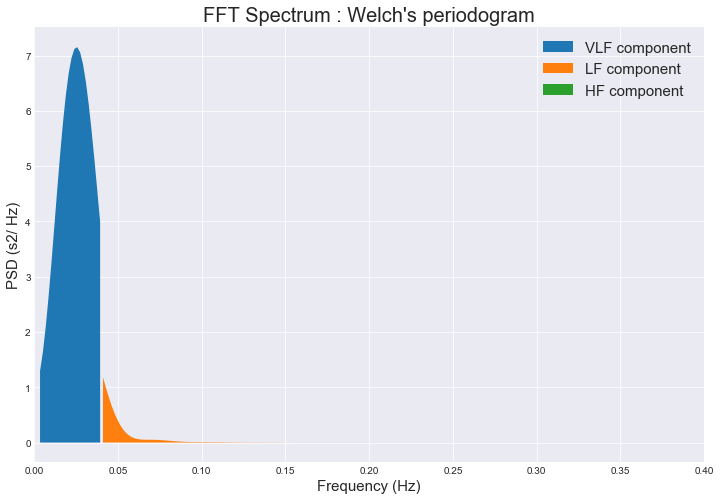

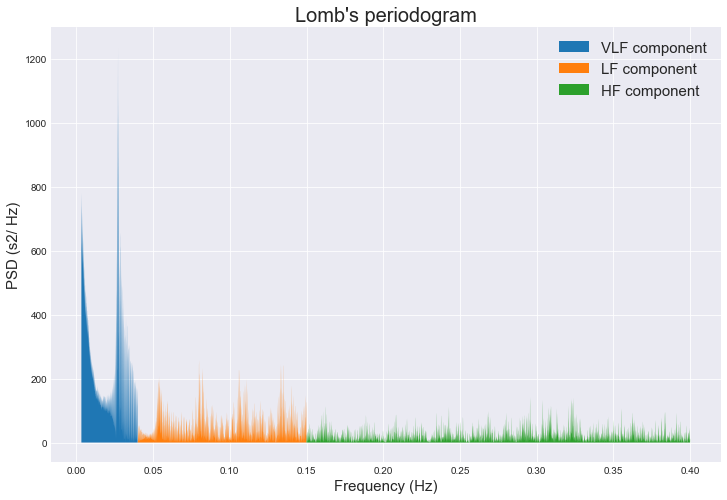

CPU times: user 735 ms, sys: 30.9 ms, total: 766 ms
Wall time: 471 ms


In [11]:
%%time
from hrvanalysis import plot_psd, plot_distrib

plot_psd(nn_ind, method="welch")
plot_psd(nn_ind, method="lomb")